In [1]:
import os
import pywt
import glob
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

2024-06-19 13:54:05.585958: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 13:54:08.876020: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Load data and preprocess

In [15]:
xTrain = np.load("./xTrain.npy")
yTrain = np.load("./yTrain.npy", allow_pickle=True)

xTest = np.load("./xTest.npy")
yTest = np.load("./yTest.npy", allow_pickle=True)

In [3]:
# Columns are:
#
# 0 = 'Beta_p'
# 1 = 'Va'
# 2 = 'Tratio'
# 3 = 'entropy'
# 4 = 'crossHelicity'
# 5 = 'residualEnergy'
# 6 = 'TotalPressure'
# 7 = 'bFluctuations'

In [16]:
# keep just SH and MO
ix = np.where( (yTest == 0) | (yTest == 4) )
xTest = xTest[ix,:]
yTest = yTest[ix]

ix = np.where( (yTrain == 0) | (yTrain == 4) )
xTrain = xTrain[ix,:]
yTrain = yTrain[ix]

xTrain = xTrain[0,:,:]
xTest = xTest[0,:,:]

ix = np.where( yTrain == 4 )
yTrain[ix] = 1

ix = np.where( yTest == 4 )
yTest[ix] = 1

In [17]:
nClasses = len( np. unique( yTrain ) )
nClasses

2

In [18]:
y = tf.one_hot(yTrain,nClasses)

### Neural Network

In [19]:
from keras import backend as K 

# Keras keeps models hanging around in memory. If we retrain a model, Keras will
# start from the previously concluded weight values. This resets everything.
K.clear_session()

In [20]:
def create_probablistic_bnn_model(rows,columns):
    
    inputs = tf.keras.layers.Input(shape=columns)
    
    hidden1 = tf.keras.layers.Dense(16, activation='relu')(inputs)    
    hidden2 = tf.keras.layers.Dense(8, activation='relu')(hidden1)
    
    distribution_params = layers.Dense(nClasses)(hidden2)
    outputs = tfp.layers.OneHotCategorical(1)(distribution_params)

    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [21]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

In [22]:
bnn = create_probablistic_bnn_model(xTrain.shape[0],xTrain.shape[1])
bnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 2)                 18        
                                                                 
 one_hot_categorical (OneHot  ((None, 2),              0         
 Categorical)                 (None, 2))                         
                                                                 
Total params: 298
Trainable params: 298
Non-trainable params: 0
_______________________________________________________________

In [11]:
bnn.compile( loss=negative_loglikelihood, metrics=['accuracy'] )

In [ ]:
history = bnn.fit( xTrain, y, epochs=200, verbose=1, 
                  use_multiprocessing=True, validation_split=0.2)

Epoch 1/200
490/490 [==============================] - 30s 52ms/step - loss: 0.6557 - accuracy: 0.5261 - val_loss: 0.6014 - val_accuracy: 0.5584
Epoch 2/200
490/490 [==============================] - 24s 49ms/step - loss: 0.5442 - accuracy: 0.6015 - val_loss: 0.5059 - val_accuracy: 0.6389
Epoch 3/200
490/490 [==============================] - 25s 51ms/step - loss: 0.4941 - accuracy: 0.6585 - val_loss: 0.4817 - val_accuracy: 0.6857
Epoch 4/200
490/490 [==============================] - 24s 50ms/step - loss: 0.4805 - accuracy: 0.6873 - val_loss: 0.4742 - val_accuracy: 0.6880
Epoch 5/200
490/490 [==============================] - 25s 50ms/step - loss: 0.4756 - accuracy: 0.6843 - val_loss: 0.4769 - val_accuracy: 0.6931
Epoch 6/200
490/490 [==============================] - 25s 50ms/step - loss: 0.4723 - accuracy: 0.6879 - val_loss: 0.4650 - val_accuracy: 0.7066
Epoch 7/200
490/490 [==============================] - 37s 75ms/step - loss: 0.4696 - accuracy: 0.6909 - val_loss: 0.4602 - val_ac

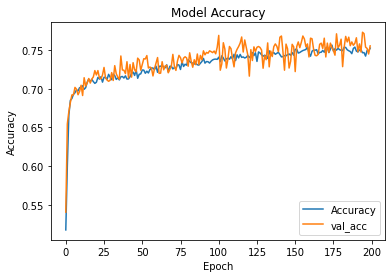

In [42]:
plt.plot( history.history['accuracy'], label="Accuracy")
plt.plot( history.history['val_accuracy'], label="val_acc")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

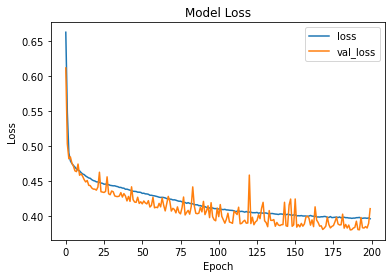

In [43]:
plt.plot( history.history['loss'], label="loss")
plt.plot( history.history['val_loss'], label="val_loss")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [44]:
# serialize weights to HDF5
bnn.save_weights("./model_weights_8PNN_binary.h5")

In [45]:
from scipy.stats import entropy

preds = []
p = bnn( xTest )
en = bnn( xTest ).entropy()

for i in range( p.shape[0] ):
    preds.append( np.argmax(p[i,:]) )

In [57]:
font = {'weight' : 'bold', 'size'   : 24}
plt.rc('font', **font)

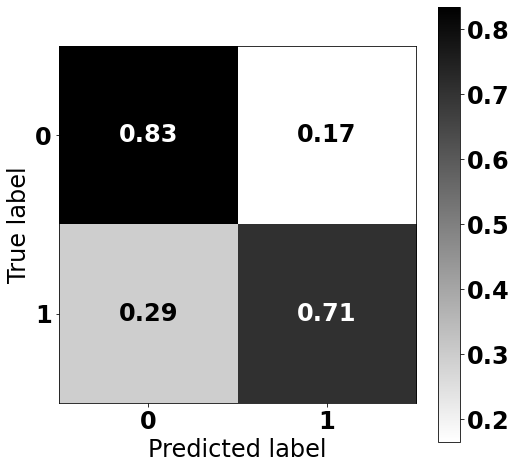

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(8, 8))

cm = confusion_matrix( yTest.astype(int), preds, normalize='true' )
disp = ConfusionMatrixDisplay( confusion_matrix=cm )
disp.plot(ax=ax, cmap='gist_yarg')

In [60]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

yTest = yTest.astype(int)

print( "Macro F1:", np.round( f1_score(yTest, preds, average='macro'), 4 ))
print( "Macro Precision:", np.round( precision_score(yTest, preds, average='macro'), 4 ))
print( "Macro Recall:", np.round( recall_score(yTest, preds, average='macro'), 4 ))
print( "Accuracy:", np.round( accuracy_score(yTest, preds), 4 ))

Macro F1: 0.7701
Macro Precision: 0.7755
Macro Recall: 0.7706
Accuracy: 0.7713


### If model is already trained - Load Saved Model

In [23]:
from keras import backend as K 

# Keras keeps models hanging around in memory. If we retrain a model, Keras will
# start from the previously concluded weight values. This resets everything.
K.clear_session()

bnn = create_probablistic_bnn_model( xTest.shape[0], xTest.shape[1] )
 
# load weights into new model
bnn.load_weights("./model_weights_8PNN_binary.h5")

In [24]:
from scipy.stats import entropy

preds = []
p = bnn( xTest )
en = bnn( xTest ).entropy()

for i in range( p.shape[0] ):
    preds.append( np.argmax(p[i,:]) )